# Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from drawRobot import *

# Variáveis globais

In [2]:
global goalPos

# Modelos cinemáticos

## Funções auxiliares

In [3]:
def calcularErros(robotState):
    xg, yg = goalPos

    x, y, theta = robotState
    
    #Erro de posição
    e = np.sqrt((xg - x) ** 2 + (yg - y) ** 2)

    phi = np.arctan2(yg - y, xg - x)

    #Erro de orientação
    alpha = phi - theta
    alpha = np.arctan2(np.sin(alpha), np.cos(alpha))  # Normalize angle to [-pi, pi]

    return e, alpha

def calcularVarControle(robotState, ref, ganhos):

    x, y, theta = robotState
    e, alpha = calcularErros(robotState)

    if ref == 'Aicardi':
        gamma, k, h = ganhos

        v = gamma*e*np.cos(alpha)
        omega = k*alpha + (v/(e*alpha))*np.sin(alpha)*(alpha + h*(alpha + theta))

    elif ref == 'Karim':
        Kv, Kw = ganhos

        v = Kv*e*np.cos(alpha)
        omega = Kw*alpha + (v/e)*np.sin(alpha)
    
    else:
        tau, kappa = ganhos

        v = tau*e*np.cos(alpha)
        omega = kappa*alpha + (v/e)*np.sin(alpha)
    
    return v, omega


## Modelos Cinemáticos

In [4]:
def cinematicModel(t, state, modo, ganhos):
    x, y, theta = state
    v, omega = calcularVarControle(state, ref=modo, ganhos=ganhos)

    #Avanço temporal do modelo
    dx = v * np.cos(theta)
    dy = v * np.sin(theta)
    dtheta = omega

    return [dx, dy, dtheta]


## Evento de parada da simulação

In [5]:
def stopEvent(t, state, modo, ganhos):
    e, alpha = calcularErros(state)
    return e - 0.01

stopEvent.terminal = True
stopEvent.direction = -1

# Simulação

## Parâmetros padrão da simulação

In [6]:
t_span = (0, 50)  # Time span for the simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points to evaluate

x0 = [0, 0, np.pi/2]  # Initial state: [x, y, theta]
goalPos = [1, 0]

## Resultados

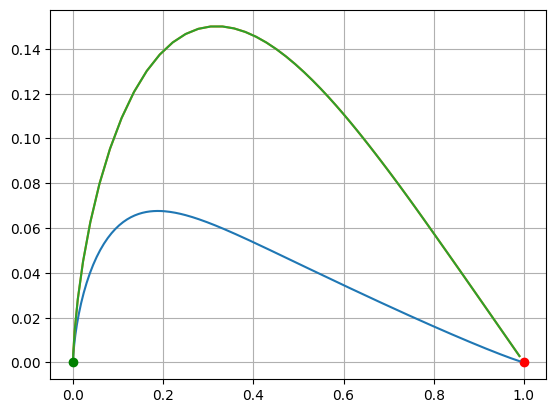

In [7]:
solutions = {}
for autor in ['Aicardi', 'Karim', 'Breno']:
    if autor == 'Aicardi':
        ganhos = [0.1, 1, 1]
    else:
        ganhos = [0.7777, 2.555]

    solutions[autor] = solve_ivp(cinematicModel, t_span=t_span, t_eval=t_eval, y0=x0, method='RK45', events=stopEvent, args=(autor, ganhos))


plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position

for key in solutions.keys():
    x, y = solutions[key].y[:2]
    plt.plot(x, y)

plt.plot(x[0], y[0], 'go')
plt.grid()

# Ortimização dos parâmetros

In [8]:
def plotResults(sol_sga, sol_fmc):
    plt.figure(figsize=(8, 5))
    plt.plot( sol_sga.y[0], sol_sga.y[1], label='SpeedyGA',   color="#1f77b4", linewidth=3)
    plotRobot(sol_sga.y[0], sol_sga.y[1], sol_sga.y[2], 0.005, color="#ff7f0e", step=3)
    plt.plot( sol_fmc.y[0], sol_fmc.y[1], label='FMinCom',    color="#9467bd", linewidth=3, linestyle='dashed')
    plotRobot(sol_fmc.y[0], sol_fmc.y[1], sol_fmc.y[2], 0.005, color="#ffbf00", step=3)
    plt.plot(x[0], y[0], 'go', label='Pos. Inicial')  # Plot goal position
    plt.plot(goalPos[0], goalPos[1], 'ro', label='Alvo')  # Plot goal position
    plt.legend()
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Trajetória do Robô')
    plt.grid()

## Referências

In [9]:
from SGA import *

x0 = [0, 0, np.pi/2]
goalPos = [1, 0]

y_ref = 0.15
v_ref = 1.2
w_ref = 300*np.pi/180

# Função para converter binário -> valor real
def bin_to_real(pop_bin, x_min=0, x_max=4):
    """Converte população binária em valores reais de x"""

    num_bits = len(pop_bin)
    resolucao = (x_max - x_min) / (2**num_bits - 1)

    valores_decimais = pop_bin.dot(2 ** np.arange(num_bits)[::-1])
    return x_min + valores_decimais * resolucao

## Fitnesses Functions

In [10]:
def fitness_function_b(pop):

    fitness_value = []
    for ind in pop:
        tau   = bin_to_real(ind[:int(0.5*len(ind))])
        kappa = bin_to_real(ind[int(0.5*len(ind)):])

        sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau, kappa]))
        x, y, theta = sol.y
        v, w = calcularVarControle(sol.y, 'Breno', [tau, kappa])

        F = 1/np.abs(np.max(np.abs(y)) - y_ref) + 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

        fitness_value.append(F)

    return fitness_value

def fitness_function_k(pop):

    fitness_value = []
    
    for ind in pop:
        Kv = bin_to_real(ind[:int(0.5*len(ind))])
        Kw = bin_to_real(ind[int(0.5*len(ind)):])

        sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [Kv, Kw]))
        e, alpha = calcularErros(sol.y)
        v, w = calcularVarControle(sol.y, 'Karim', [Kv, Kw])

        J = np.trapz((e/e[0])**2 + (alpha/alpha[0])**2, sol.t)
        F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

        fitness_value.append(F - J)
    
    return fitness_value

def fitness_function_a(pop):

    fitness_values = []
    for ind in pop:
        gamma  = bin_to_real(ind[:int(1/3*len(ind))], 0, 4)
        k      = bin_to_real(ind[int(1/3*len(ind)):int(2/3*len(ind))], 0, 4)
        h      = bin_to_real(ind[int(2/3*len(ind)):], 0, 4)

        sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Aicardi', [gamma, k, h]))
        v, w = calcularVarControle(sol.y, 'Aicardi', [gamma, k, h])

        F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

        fitness_values.append(F)

    return fitness_values

## Costs Functions

In [15]:
def cost_function_b(params):

    tau, kappa = params

    sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau, kappa]))
    x, y, theta = sol.y
    v, w = calcularVarControle(sol.y, 'Breno', [tau, kappa])

    F = 1/np.abs(np.max(np.abs(y)) - y_ref) + 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

    return -F

def cost_function_k(params):
    Kv, Kw = params

    sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [Kv, Kw]))
    e, alpha = calcularErros(sol.y)
    v, w = calcularVarControle(sol.y, 'Karim', [Kv, Kw])

    J = np.trapz((e/e[0])**2 + (alpha/alpha[0])**2, sol.t)
    F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

    return -(F - J)

def cost_function_a(params):

    gamma, k, h = params

    sol = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Aicardi', [gamma, k, h]))
    v, w = calcularVarControle(sol.y, 'Aicardi', [gamma, k, h])

    F = 1/np.abs(np.max(np.abs(v)) - v_ref) + 1/np.abs(np.max(np.abs(w)) - w_ref)

    return -F



## Breno

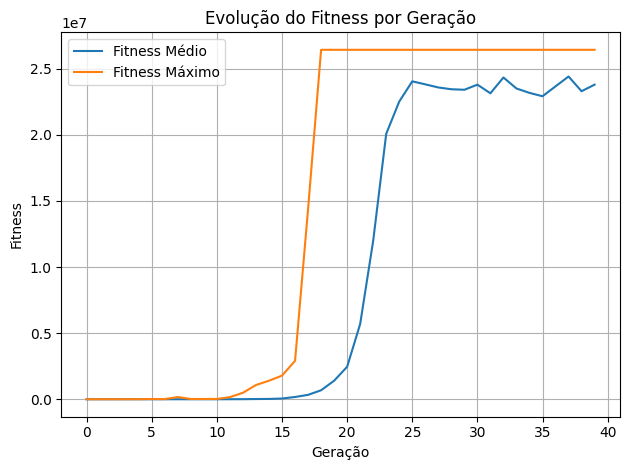

Optimization terminated successfully    (Exit mode 0)
            Current function value: -5498.178699687315
            Iterations: 10
            Function evaluations: 38
            Gradient evaluations: 6


,SpeedyGA,FMinCom
Tau,0.986108,1.205904
Kappa,3.242564,3.959151
Max y,0.150000,0.150182
Max v,0.756624,0.926347
Max w,291.830799,356.323620


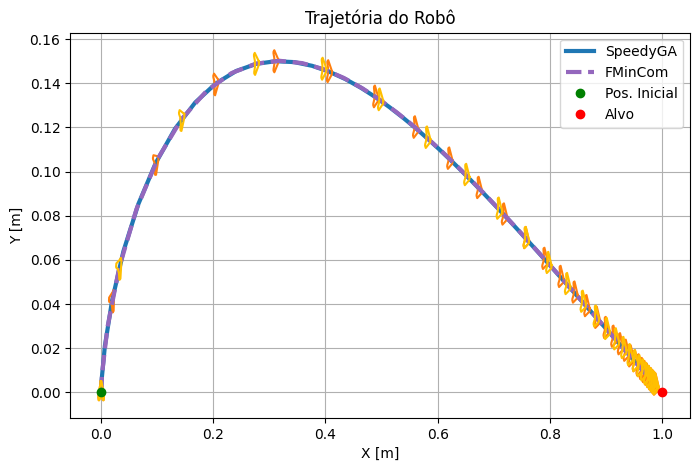

In [17]:
"""### SpeedyGA ###"""
best = evolve(fitnessFunction=fitness_function_b, length=40, popSize=200, maxGens=40, probMutation=0.003, probCrossover=1)

tau_best   = bin_to_real(best[:int(0.5*len(best))])
kappa_best = bin_to_real(best[int(0.5*len(best)):])

sol_sga = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau_best, kappa_best]))
x, y, theta = sol_sga.y
v, w = calcularVarControle(sol_sga.y, 'Breno', [tau_best, kappa_best])

speedyGA_results = [tau_best, kappa_best, max(np.abs(y)), max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### FMinCom ###"""
controlVar_guess_b = [0.1, 1]  # Initial guess for tau and kappa
bounds = [(0, 4), (0, 4)]  # Bounds for tau and kappa

result = minimize(cost_function_b, controlVar_guess_b, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

tau_best = result.x[0]
kappa_best = result.x[1]

sol_fmc = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Breno', [tau_best, kappa_best]))
x, y, theta = sol_fmc.y
v, w = calcularVarControle(sol_fmc.y, 'Breno', [tau_best, kappa_best])

fmincom_results = [tau_best, kappa_best, max(np.abs(y)), max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### Resultados ###"""
res = pd.DataFrame({
    'SpeedyGA': speedyGA_results,
    'FMinCom': fmincom_results
}, index=['Tau', 'Kappa', 'Max y', 'Max v', 'Max w'])

display(res)

plotResults(sol_fmc=sol_fmc, sol_sga=sol_sga)


## Karim

C:\Users\Matheus Lucas\AppData\Local\Temp\ipykernel_13484\3829710024.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J = np.trapz((e/e[0])**2 + (alpha/alpha[0])**2, sol.t)


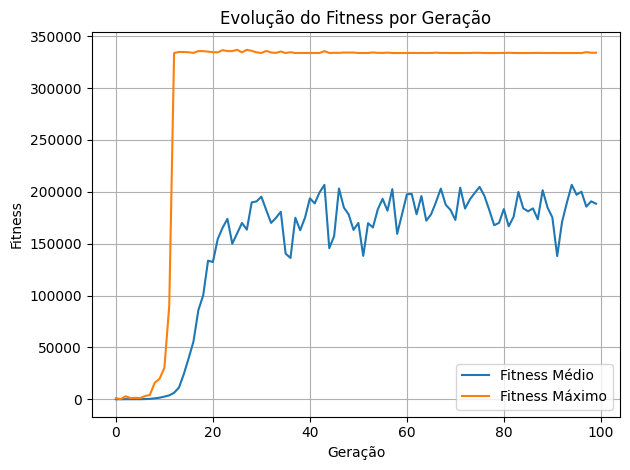

C:\Users\Matheus Lucas\AppData\Local\Temp\ipykernel_13484\3701616419.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J = np.trapz((e/e[0])**2 + (alpha/alpha[0])**2, sol.t)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4932684.282385776
            Iterations: 12
            Function evaluations: 98
            Gradient evaluations: 12


,SpeedyGA,FMinCom
Kv,1.698587,1.870804
Kw,3.333331,2.209782
Max v,1.200321,1.200000
Max w,299.999828,198.880418


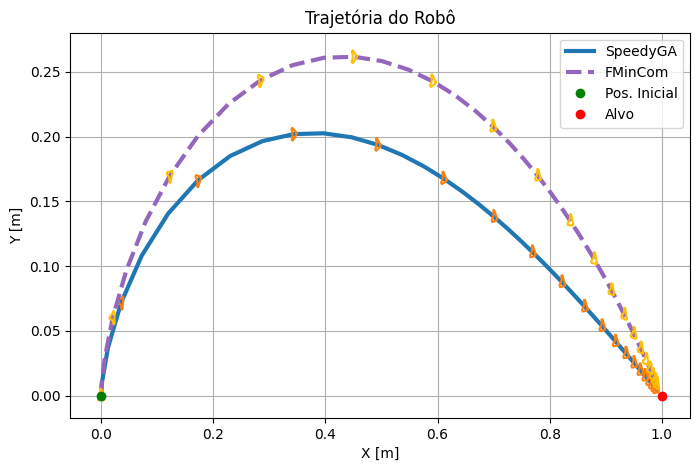

In [13]:
"""### SpeedyGA ###"""
best = evolve(fitnessFunction=fitness_function_k, length=40, popSize=100, maxGens=100, probMutation=0.03, probCrossover=1)

Kv_best = bin_to_real(best[:int(0.5*len(best))])
Kw_best = bin_to_real(best[int(0.5*len(best)):])

sol_sga = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [Kv_best, Kw_best]))
x, y, theta = sol_sga.y
v, w = calcularVarControle(sol_sga.y, 'Karim', [Kv_best, Kw_best])

speedyGA_results = [Kv_best, Kw_best, max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### FMinCom ###"""
controlVar_guess_k = [0.1, 1]  # Initial guess for Kv and Kw
bounds = [(0, 4), (0, 4)]  # Bounds for tau and kappa

result = minimize(cost_function_k, controlVar_guess_k, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

Kv_best = result.x[0]
Kw_best = result.x[1]

sol_fmc = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Karim', [Kv_best, Kw_best]))
x, y, theta = sol_fmc.y
v, w = calcularVarControle(sol_fmc.y, 'Karim', [Kv_best, Kw_best])

fmincom_results = [Kv_best, Kw_best, max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### Resultados ###"""
res = pd.DataFrame({
    'SpeedyGA': speedyGA_results,
    'FMinCom': fmincom_results
}, index=['Kv', 'Kw', 'Max v', 'Max w'])

display(res)

plotResults(sol_fmc=sol_fmc, sol_sga=sol_sga)

## Aicardi

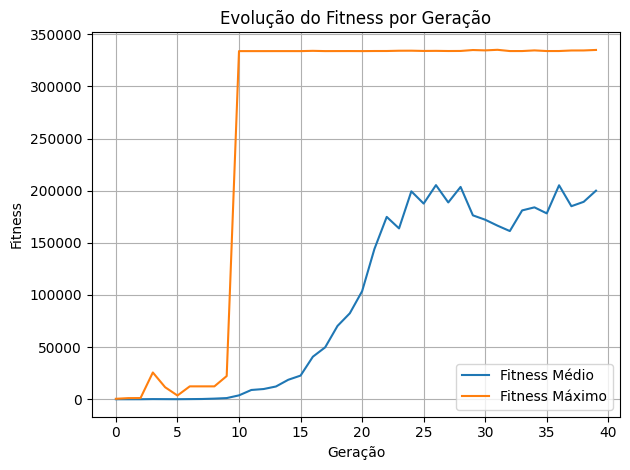

Optimization terminated successfully    (Exit mode 0)
            Current function value: -570338.9008840106
            Iterations: 25
            Function evaluations: 190
            Gradient evaluations: 25


,SpeedyGA,FMinCom
gamma,1.628027,3.384986
k,3.333335,2.744850
h,3.472503,2.264869
Max v,1.199209,2.166863
Max w,300.000172,299.999900


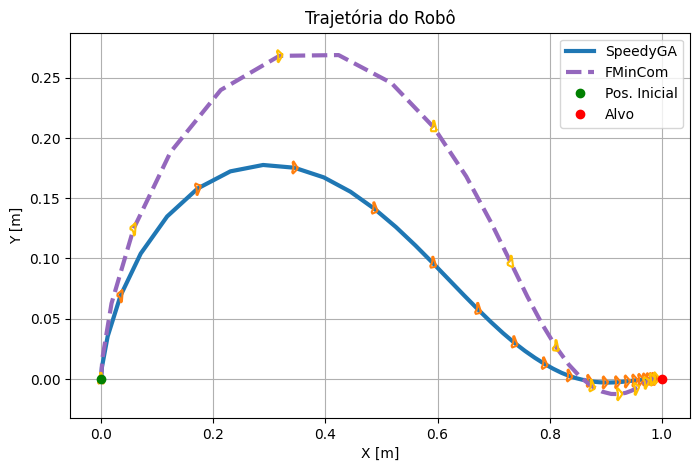

In [14]:
"""### SpeedyGA ###"""
best = evolve(fitnessFunction=fitness_function_a, length=60, popSize=200, maxGens=40, probMutation=0.03, probCrossover=1)

gamma_best   = bin_to_real(best[:int(1/3*len(best))], 0, 4)
k_best       = bin_to_real(best[int(1/3*len(best)):int(2/3*len(best))], 0, 4)
h_best       = bin_to_real(best[int(2/3*len(best)):], 0, 4)

sol_sga = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Aicardi', [gamma_best, k_best, h_best]))
x, y, theta = sol_sga.y
v, w = calcularVarControle(sol_sga.y, 'Aicardi', [gamma_best, k_best, h_best])

speedyGA_results = [gamma_best, k_best, h_best, max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### FMinCom ###"""
controlVar_guess_a = [0.1, 1, 1]  # Initial guess for Kv and Kw
bounds = [(0, 4), (0, 4), (0, 4)]  # Bounds for tau and kappa

result = minimize(cost_function_a, controlVar_guess_a, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

gamma_best   = result.x[0]
k_best       = result.x[1]
h_best       = result.x[2]

sol_fmc = solve_ivp(cinematicModel, t_span=t_span, y0 = x0, t_eval=t_eval, method='RK45', events=stopEvent, args=('Aicardi', [gamma_best, k_best, h_best]))
x, y, theta = sol_fmc.y
v, w = calcularVarControle(sol_fmc.y, 'Aicardi', [gamma_best, k_best, h_best])

fmincom_results = [gamma_best, k_best, h_best, max(np.abs(v)), max(np.abs(w*180/np.pi))]

"""### Resultados ###"""
res = pd.DataFrame({
    'SpeedyGA': speedyGA_results,
    'FMinCom': fmincom_results
}, index=['gamma', 'k', 'h', 'Max v', 'Max w'])

display(res)

plotResults(sol_fmc=sol_fmc, sol_sga=sol_sga)